In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
class MLQPLayer(tf.keras.layers.Layer):
    def __init__(self, n_outputs):
        super(MLQPLayer, self).__init__()
        self.n_outputs = n_outputs

    def build(self, input_shape):
        self.mu = self.add_weight('mu', shape=[int(input_shape[-1]), self.n_outputs])
        self.nu = self.add_weight('nu', shape=[int(input_shape[-1]), self.n_outputs])
        self.bias = self.add_weight('bias', shape=[1, self.n_outputs])

    def call(self, inputs, *args, **kwargs):
        return tf.matmul(inputs*inputs, self.mu) + tf.matmul(inputs, self.nu) + self.bias

In [7]:
learning_rate = 0.1
training_epochs = 5000
display_step = 100
n_idle_epochs = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.00001)

def scheduler(epoch, lr):
    if lr <= 0.01:
        return lr
    if epoch % 200 == 0:
        return lr * 0.8
        # return lr * 0.9   # best
    else:
        return lr
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

class NEPOCHLogger(tf.keras.callbacks.Callback):
    def __init__(self, per_epoch=100):
        super(NEPOCHLogger, self).__init__()
        self.seen = 0
        self.per_epoch = per_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.per_epoch == 0:
            print('Epoch {}, loss {:.8f}, mae {:.8f}'.format(epoch, logs['loss'], logs['mae']))

log_display = NEPOCHLogger(per_epoch=display_step)
train_data = pd.read_csv(r'two_spiral_train_data.txt', header=None, sep='\s+')
test_data = pd.read_csv(r'two_spiral_test_data.txt', header=None, sep='\s+')
train_data['class_0'] = train_data[2].apply(lambda x: 1 if x == 0 else 0)
train_data['class_1'] = train_data[2].apply(lambda x: 1 if x == 1 else 0)
test_data['class_0'] = test_data[2].apply(lambda x: 1 if x == 0 else 0)
test_data['class_1'] = test_data[2].apply(lambda x: 1 if x == 1 else 0)

train_X = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 0:2]))
train_y = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 2]))
test_X = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 0:2]))
test_y = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 2]))

model = tf.keras.Sequential([
    MLQPLayer(128),
    tf.keras.layers.Activation('tanh'),
    MLQPLayer(1),
    tf.keras.layers.Activation('sigmoid')
])

optimizer = tf.keras.optimizers.SGD(learning_rate)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [11]:
history = model.fit(train_X, train_y, epochs=training_epochs, verbose=0, batch_size=16, callbacks=[log_display])
print("Train Finished!", history)

y_hat_train = model.predict(train_X, verbose=0)
y_hat_test = model.predict(test_X, verbose=0)
print('total number of test samples: %d' % len(test_y))
print(model.evaluate(test_X, test_y, verbose=0))

Epoch 0, loss 0.00060474, mae 0.01738134
Epoch 100, loss 0.00057219, mae 0.01720876
Epoch 200, loss 0.00055277, mae 0.01686109
Epoch 300, loss 0.00054522, mae 0.01673839
Epoch 400, loss 0.00051279, mae 0.01639286
Epoch 500, loss 0.00049584, mae 0.01620405
Epoch 600, loss 0.00048844, mae 0.01598911
Epoch 700, loss 0.00047554, mae 0.01585422
Epoch 800, loss 0.00046056, mae 0.01564894
Epoch 900, loss 0.00044743, mae 0.01540093
Epoch 1000, loss 0.00043551, mae 0.01526951
Epoch 1100, loss 0.00042863, mae 0.01512496
Epoch 1200, loss 0.00041626, mae 0.01491857
Epoch 1300, loss 0.00040441, mae 0.01463658
Epoch 1400, loss 0.00039507, mae 0.01457772
Epoch 1500, loss 0.00039567, mae 0.01439826
Epoch 1600, loss 0.00037932, mae 0.01426755
Epoch 1700, loss 0.00036114, mae 0.01402140
Epoch 1800, loss 0.00035965, mae 0.01391713
Epoch 1900, loss 0.00035343, mae 0.01382892
Epoch 2000, loss 0.00034686, mae 0.01364374
Epoch 2100, loss 0.00034008, mae 0.01351661
Epoch 2200, loss 0.00032924, mae 0.01340643


In [12]:
class_0_area, class_1_area = {}, {}
for x in np.arange(-6, 6.1, 0.5):
    for y in np.arange(-6, 6.1, 0.5):
        if model.predict([[x, y]], verbose=0)[0][0] > 0.5:
            class_1_area.setdefault('x', []).append(x)
            class_1_area.setdefault('y', []).append(y)
        else:
            class_0_area.setdefault('x', []).append(x)
            class_0_area.setdefault('y', []).append(y)

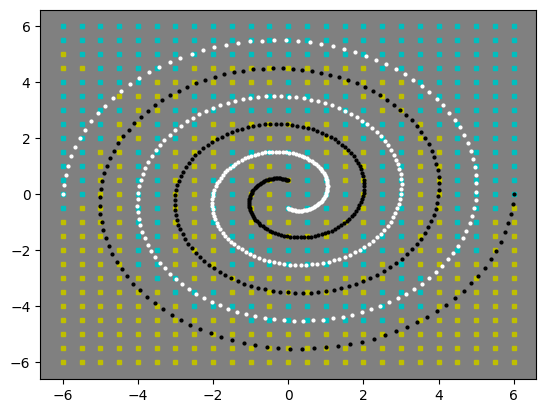

In [13]:
class_0, class_1 = {}, {}
for X, y in zip(np.concatenate([train_X.numpy(), test_X.numpy()], 0), np.concatenate([train_y.numpy(), test_y.numpy()], 0)):
    if y == 0:
        class_0.setdefault('x', []).append(X[0])
        class_0.setdefault('y', []).append(X[1])
    else:
        class_1.setdefault('x', []).append(X[0])
        class_1.setdefault('y', []).append(X[1])
plt.axes().set_facecolor('gray')
plt.plot(class_0_area['x'], class_0_area['y'], 'cs', markersize=3, label='class 0 area')
plt.plot(class_1_area['x'], class_1_area['y'], 'ys', markersize=3, label='class 1 area')
plt.plot(class_0['x'], class_0['y'], 'wo', markersize=2, label='class 0')
plt.plot(class_1['x'], class_1['y'], 'o', markersize=2, color='#000000', label='class 1')
plt.show()